# Case study: Loan Payment Prediction

###  Problem Statement: Produce a supervised machine learning model to predict whether a load will be paid in full or charged off

## Step One: Data processing and cleaning

In [165]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import datetime as dt

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

In [166]:
# model build
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc

In [167]:
# Load the data to Pandas
df=pd.read_csv('BMO_MLCoE_CaseStudy_Dataset.csv',low_memory=False)

In [168]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648.0,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62,NaN,May-19,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,NaN,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687.0,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66,NaN,Oct-16,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,NaN,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.50%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0

In [169]:
df.shape

(42538, 144)

In [ ]:
# Check the column information:
list(df.columns)

In [171]:
# Check the target variable - loan_status
df['loan_status'].value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

Usually for loan applications which **didn't meet credit policy**, they should be declined directly before sent to the model.
Although, in this case these loans still had 'Status' information, we **would remove these records from build model and assume these loans won't be processed by the model** 

In [172]:
# Only keep records which passed credit policy:
df=df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [173]:
df['loan_status'].value_counts()

Fully Paid     34116
Charged Off     5670
Name: loan_status, dtype: int64

In [174]:
# Define a function to check missing values

# Function to calculate missing rate for columns WITH missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [175]:
missing=missing_values_table(df)
missing

Your selected dataframe has 144 columns.
There are 102 columns that have missing values.


,Missing Values,% of Total Values
id,39786,100.0
num_tl_30dpd,39786,100.0
revol_bal_joint,39786,100.0
total_il_high_credit_limit,39786,100.0
total_bc_limit,39786,100.0
total_bal_ex_mort,39786,100.0
tot_hi_cred_lim,39786,100.0
percent_bc_gt_75,39786,100.0
pct_tl_nvr_dlq,39786,100.0
num_tl_op_past_12m,39786,100.0


In [176]:
# Drop columns with a high percentage of missing vlaues - in this cause, we use 80%
missing_columns = list(missing.index[missing['% of Total Values'] > 80])
df2 = df.drop(columns = missing_columns)
missing_values_table(df2)

Your selected dataframe has 54 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
mths_since_last_delinq,25727,64.7
desc,12967,32.6
emp_title,2467,6.2
emp_length,1078,2.7
pub_rec_bankruptcies,697,1.8
last_pymnt_d,71,0.2
collections_12_mths_ex_med,56,0.1
chargeoff_within_12_mths,56,0.1
revol_util,50,0.1
tax_liens,39,0.1


In [177]:
# Check and Remove duplicates
df2[df2.duplicated()]
df2.drop_duplicates(inplace= True)
df2.shape

(39786, 54)

## Step Two: Exploratory Data Analysis

###### 2.1 Check whether the data is balanced or imbalanced

In [178]:
# Encode the target variable as 1 for 'Charged Off' and 0 for 'Fully Paid'
df2['target'] = df2['loan_status'].apply(lambda x:1 if x == 'Charged Off' else 0)

In [179]:
# Calculate the charge off rate
df2.target.sum() / df2.shape[0] * 100

14.251244156235861

The data is imbalanced

##### 2.2 Drop Columns May Cause Data Leakge

In [180]:
data_leakage_cols = ['funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
                     'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
                     'last_pymnt_amnt','chargeoff_within_12_mths','debt_settlement_flag']

In [181]:
df2.drop(columns=data_leakage_cols, inplace=True)

##### 2.3 Explore numerical features

In [182]:
# Basic descriptive statistics view
df2.describe()

,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,collections_12_mths_ex_med,policy_code,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,target
count,39786.000000,39786.000000,3.978600e+04,39786.000000,39786.000000,39786.000000,14059.000000,39786.000000,39786.000000,39786.000000,39786.000000,39786.0,39786.0,39730.0,39786.0,39786.0,39786.0,39089.000000,39747.0,39786.000000
mean,11231.360277,324.733637,6.897907e+04,13.317794,0.146534,0.869049,35.901913,9.294023,0.055145,13391.983914,22.090308,0.0,0.0,0.0,1.0,0.0,0.0,0.043286,0.0,0.142512
std,7464.542832,208.923212,6.376263e+04,6.678300,0.491826,1.070069,22.017895,4.399997,0.237653,15894.635107,11.401620,0.0,0.0,0.0,0.0,0.0,0.0,0.204381,0.0,0.349579
min,500.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
25%,5500.000000,167.080000,4.050000e+04,8.180000,0.000000,0.000000,18.000000,6.000000,0.000000,3704.250000,13.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
50%,10000.000000,280.610000,5.900000e+04,13.410000,0.000000,1.000000,34.000000,9.000000,0.000000,8859.500000,20.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
75%,15000.000000,430.780000,8.234250e+04,18.600000,0.000000,1.000000,52.000000,12.000000,0.000000,17065.000000,29.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000
max,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,90.000000,0.0,0.0,0.0,1.0,0.0,0.0,2.000000,0.0,1.000000


In [183]:
df2.delinq_amnt.value_counts()

0.0    39786
Name: delinq_amnt, dtype: int64

In [184]:
#Drop columns with constant values:
# collections_12_mths_ex_med, tax_liens,out_prncp,out_prncp_inv,delinq_amnt,acc_now_delinq 
df2.drop(columns=['collections_12_mths_ex_med','tax_liens','out_prncp','out_prncp_inv','delinq_amnt','acc_now_delinq'], inplace=True)

##### 2.4 Features Binning

**Only do for one variable to save time: `mths_since_last_delinq`**
- -1 'no delinq'
- 0-1 '<1 month'
- 1-3 '<3 months'
- 3-6 '<6 months'
- 6-12 '<1 year'
- 12-24 '<2 years'
- 24-36 '<3 years'
- 36-48 '<4 years'
- 48-60 '<5 years'
- 60-72 '<6 years'
- 72-84 '<7 years'
- 84-121 '<10 years'

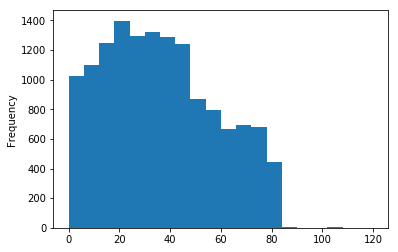

In [185]:
df2['mths_since_last_delinq'].plot(kind='hist',bins=20)

In [186]:
# binning for feature - mths_since_last_delinq
df2['mths_since_last_delinq'].fillna(value = -1, inplace = True)
mths_delinq_bins_boundaries = [-1,0,2,4,7,13,25,37,49,61,73,85,121]
mths_delinq_bins_labels = ['no_delinq', '0-1months', '1-3months','3-6months','6months-1year','1-2years','2-3years','3-4years','4-5years','5-6years','6-7years','7-10years']
df2['mths_since_last_delinq_cat'] = pd.cut(df2['mths_since_last_delinq'], bins=mths_delinq_bins_boundaries, labels=mths_delinq_bins_labels, right=False)

In [187]:
df2.drop(columns=['mths_since_last_delinq'], inplace=True)

##### 2.5 Explore Categorical features

In [188]:
print(df2.info(0))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39786 entries, 0 to 39785
Data columns (total 37 columns):
loan_amnt                     39786 non-null float64
term                          39786 non-null object
int_rate                      39786 non-null object
installment                   39786 non-null float64
grade                         39786 non-null object
sub_grade                     39786 non-null object
emp_title                     37319 non-null object
emp_length                    38708 non-null object
home_ownership                39786 non-null object
annual_inc                    39786 non-null float64
verification_status           39786 non-null object
issue_d                       39786 non-null object
loan_status                   39786 non-null object
pymnt_plan                    39786 non-null object
desc                          26819 non-null object
purpose                       39786 non-null object
title                         39775 non-null object
zip_

In [189]:
# Create a separate DataFrame consisting of only categorical features
df_cat=df2.select_dtypes(include=['object','category'])
df_cat.head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,mths_since_last_delinq_cat
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,Jan-85,83.70%,f,Jan-15,May-19,Individual,N,no_delinq
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-99,9.40%,f,Apr-13,Oct-16,Individual,N,no_delinq
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,Fully Paid,n,NaN,small_business,real estate business,606xx,IL,Nov-01,98.50%,f,Jun-14,Jun-17,Individual,N,no_delinq
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,Fully Paid,n,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,Feb-96,21%,f,Jan-15,Apr-16,Individual,N,2-3years
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,Fully Paid,n,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,Jan-96,53.90%,f,Jan-17,Apr-18,Individual,N,3-4years


In [ ]:
# Drop the target column and create a list with all categorical columns
cat_columns=list(df_cat.drop(columns=['loan_status']).columns)
cat_columns

In [191]:
# Strip leading and trailing space of each categorical column
for i in cat_columns:   
    df2[i] = df2[i].str.strip()

In [192]:
# Quickly explore each each categorical feature and check the frequency:
pd.set_option('display.max_columns', None)
df2[cat_columns].head(5)

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,mths_since_last_delinq_cat
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-11,n,Borrower added on 12/22/11 > I need to upgrade...,credit_card,Computer,860xx,AZ,Jan-85,83.70%,f,Jan-15,May-19,Individual,N,no_delinq
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,n,Borrower added on 12/22/11 > I plan to use thi...,car,bike,309xx,GA,Apr-99,9.40%,f,Apr-13,Oct-16,Individual,N,no_delinq
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,n,NaN,small_business,real estate business,606xx,IL,Nov-01,98.50%,f,Jun-14,Jun-17,Individual,N,no_delinq
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,n,Borrower added on 12/21/11 > to pay for proper...,other,personel,917xx,CA,Feb-96,21%,f,Jan-15,Apr-16,Individual,N,2-3years
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,n,Borrower added on 12/21/11 > I plan on combini...,other,Personal,972xx,OR,Jan-96,53.90%,f,Jan-17,Apr-18,Individual,N,3-4years


In [ ]:
# check frequency
for i in cat_columns:
    print(df2[i].value_counts().to_frame())

In [ ]:
df2['emp_title'].value_counts()

In [ ]:
df2['title'].value_counts()

In [196]:
df2['application_type'].value_counts()

Individual    39786
Name: application_type, dtype: int64

After the exploratory analysis, we have a few findings:

1. **'desc'** is not relevant to the mdoel build and should be dropped

2. Drop all **date columns** to simplify the model build in this case. If we have more time, we can do some feature engineering by using date features, e.g. df_loan['issue_to_earliest_cr_line'] = df_loan['issue_d'] - df_loan['earliest_cr_line']

3. **'pmnt_plan','hardship_flag','initial_list_status' and 'application_type'** only have constant values and are useless for model build

4. **'emp_title', 'zip_code', and 'title'** have too many unique values and are not informative, we should drop them 

5. To simplify the analysis, we only **keep 'grade' and drop 'sub_grade'**

6. Also, some types of information filled in by customer are very difficult to verify (customers can put whatever they want to). To simplify the analysis for this case, we should drop these columns that cann't be easily verified: **'emp_length', 'purpose'**

Finally, we create a list including all categorical columns should be dropped

In [197]:
drop_feature=['desc','issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line', 'pymnt_plan','hardship_flag', 'emp_title',
             'emp_length', 'zip_code','title', 'purpose','sub_grade','initial_list_status','application_type']

In [198]:
# Drop thoes features
df2 = df2.drop(columns=drop_feature, axis = 1)

In [ ]:
df2.head(5)

In [200]:
remaining_cat_fea=[i for i in cat_columns if i not in drop_feature]
remaining_cat_fea

['term',
 'int_rate',
 'grade',
 'home_ownership',
 'verification_status',
 'addr_state',
 'revol_util',
 'mths_since_last_delinq_cat']

##### 2.6 Encode remaining categorical features

In [ ]:
# Convert 'revol_util' into a numerical feature:
df2['revol_util'].value_counts()

In [ ]:
df2['revol_util'] = df2['revol_util'].str.replace('%', '').astype(float)/100
df2['revol_util'].value_counts()

In [ ]:
# Convert 'interest rate' into a numerical feature:
df2['int_rate'].value_counts()

In [ ]:
df2['int_rate'] = df2['int_rate'].str.replace('%', '').astype(float)/100
df2['int_rate'].value_counts()

In [205]:
# Convert 'verification_status' into a numerical feature:
df2['verification_status'].value_counts()

Not Verified       16926
Verified           12844
Source Verified    10016
Name: verification_status, dtype: int64

In [206]:
df2['verification_status'] = df2['verification_status'].apply(lambda x: 0 if x == 'Not Verified' else 1)
df2['verification_status'].value_counts()

1    22860
0    16926
Name: verification_status, dtype: int64

In [207]:
# Check remaining categorical features:
list(df2.select_dtypes(include=['object']).columns)

['term',
 'grade',
 'home_ownership',
 'loan_status',
 'addr_state',
 'mths_since_last_delinq_cat']

In [208]:
# remove 'loan_status'
df2=df2.drop(columns=['loan_status'])

##### 2.7 One-hot encoding for remaining categorical features:

In [209]:
def cate_convert(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [210]:
df2,cat_cols = cate_convert(df2, nan_as_category = True)

In [211]:
df2.head()

,loan_amnt,int_rate,installment,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,pub_rec_bankruptcies,target,term_36 months,term_60 months,term_nan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,mths_since_last_delinq_cat_0-1months,mths_since_last_delinq_cat_1-2years,mths_since_last_delinq_cat_1-3months,mths_since_last_delinq_cat_2-3years,mths_since_last_delinq_cat_3-4years,mths_since_last_delinq_cat_3-6months,mths_since_last_delinq_cat_4-5years,mths_since_last_delinq_cat_5-6years,mths_since_last_delinq_cat_6-7years,mths_since_last_delinq_cat_6months-1year,mths_since_last_delinq_cat_7-10years,mths_since_last_delinq_cat_no_delinq,mths_since_last_delinq_cat_nan
0,5000.0,0.1065,162.87,24000.0,1,27.65,0.0,1.0,3.0,0.0,13648.0,0.837,9.0,1.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2500.0,0.1527,59.83,30000.0,1,1.00,0.0,5.0,3.0,0.0,1687.0,0.094,4.0,1.0,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2400.0,0.1596,84.33,12252.0,0,8.72,0.0,2.0,2.0,0.0,2956.0,0.985,10.0,1.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,10000.0,0.1349,339.31,49200.0,1,20.00,0.0,1.0,10.0,0.0,5598.0,0.210,37.0,1.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,3000.0,0.1269,67.79,80000.0,1,17.94,0.0,0.0,15.0,0.0,27783.0,0.539,38.0,1.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


###### 2.8 Missing value imputation

In [212]:
missing=missing_values_table(df2)
missing

Your selected dataframe has 97 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
pub_rec_bankruptcies,697,1.8
revol_util,50,0.1


In [213]:
df2['pub_rec_bankruptcies'].fillna(value=0,inplace=True)
df2['revol_util'].fillna(value=0,inplace=True)
missing=missing_values_table(df2)
missing

Your selected dataframe has 97 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [214]:
final=df2.copy()
df2.to_csv('final_dataset_for_model.csv')

## Step Three: ML Modelling

###### 3.1 Check Correlations

In [215]:
correlations = final.corr()['target'].dropna().sort_values(ascending = False)

In [216]:
# Display correlations
print('Top Positive Correlations:\n', correlations.head(15))
print('\nTop Negative Correlations:\n', correlations.tail(15))

Top Positive Correlations:
 target                  1.000000
int_rate                0.197918
term_60 months          0.149151
revol_util              0.095925
grade_E                 0.088464
grade_D                 0.078370
grade_F                 0.077362
inq_last_6mths          0.071325
pub_rec                 0.050927
loan_amnt               0.050035
pub_rec_bankruptcies    0.047140
grade_G                 0.044960
dti                     0.041984
verification_status     0.038998
grade_C                 0.035708
Name: target, dtype: float64

Top Negative Correlations:
 addr_state_VA                          -0.008817
open_acc                               -0.010199
addr_state_NY                          -0.010491
addr_state_MA                          -0.012153
addr_state_WY                          -0.012336
addr_state_PA                          -0.012936
addr_state_DC                          -0.015234
addr_state_TX                          -0.019222
total_acc                  

##### 3.2 Split into Test and Train datasets before doing upsampling

In [217]:
x=final.drop(columns='target')
y=final['target']

In [218]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(29839, 96)
(29839,)
(9947, 96)
(9947,)


###### 3.3 Blance the data - Upsample

In this case, the target is imbalanced, so we will upsample the 'charge off' class

In [219]:
# Concatenate the train data back together
Z = pd.concat([x_train, y_train], axis=1)
Z['target'].value_counts()

0    25652
1     4187
Name: target, dtype: int64

In [220]:
# Separate minority and majority classes
not_chargeoff = Z[Z['target']==0]
chargeoff = Z[Z['target']==1]
len(not_chargeoff)

25652

In [221]:
chargeoff_upsmapled = resample(chargeoff, replace = True, n_samples = len(not_chargeoff),random_state=12345)
len(chargeoff_upsmapled)

25652

In [222]:
# combine majority and upsampled minority
upsampled = pd.concat([not_chargeoff, chargeoff_upsmapled])
upsampled['target'].value_counts()

1    25652
0    25652
Name: target, dtype: int64

In [223]:
# Generate x_train and y_train again with the balanced dataset
y_train = upsampled['target']
x_train = upsampled.drop(columns='target', axis=1)

###### 3.3 logistic regression model

In [224]:
logist= LogisticRegression()

In [225]:
logist.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# Get the coefficient list
coefficients = pd.concat([pd.DataFrame(list(x_train.columns)),pd.DataFrame(np.transpose(logist.coef_))], axis = 1)
coefficients

**Check key metrics**

In [227]:
log_reg_pred = logist.predict_proba(x_test)
y_pred_proba=log_reg_pred[:,1]
y_pred = logist.predict(x_test)

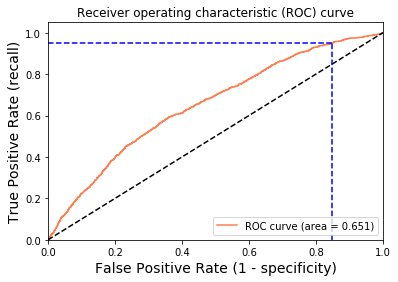

In [228]:
# Show the ROC_CURVE
import numpy as np
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensibility > 0.95
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [229]:
# Classification_report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.59      0.72      8464
           1       0.21      0.62      0.32      1483

   micro avg       0.60      0.60      0.60      9947
   macro avg       0.56      0.61      0.52      9947
weighted avg       0.80      0.60      0.66      9947



In [230]:
# Accuracy:
# Compare test and train results to see whether we overfitting
y_train_pred=logist.predict(x_train)
print('Train Sample Accuracy: %0.4f' % accuracy_score(y_train, y_train_pred))
print('Test Sample Accuracy: %0.4f' % accuracy_score(y_test, y_pred))

Train Sample Accuracy: 0.6114
Test Sample Accuracy: 0.5978


###### 3.4 Random Forest

In [231]:
# create a random forest classifier 
rf_model = RandomForestClassifier()

In [232]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5
)

rf_model.fit(X=x_train, y=y_train)

# For illustration purposes, we are instructing the model to build 200 trees, 
# where each tree can only grow up to the depth of 5

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
# Get the feature importances for each feature using the following code
rf_model.feature_importances_

In [234]:
# Associate these feature importances with the corresponding features
feature_importance_df = pd.DataFrame(list(zip(rf_model.feature_importances_, list(x_train.columns))))
feature_importance_df.columns = ['feature.importance', 'feature']
feature_importance_df.sort_values(by='feature.importance', ascending=False).head(20) # only show top 20

,feature.importance,feature
1,0.218380,int_rate
18,0.132403,grade_A
16,0.118572,term_60 months
15,0.102882,term_36 months
11,0.073835,revol_util
3,0.054894,annual_inc
21,0.037642,grade_D
7,0.035283,inq_last_6mths
22,0.031150,grade_E
0,0.019847,loan_amnt


**Check key metrics**

In [235]:
rf_model_pred = rf_model.predict_proba(x_test)
y_pred_proba=rf_model_pred[:,1]
y_pred = rf_model.predict(x_test)

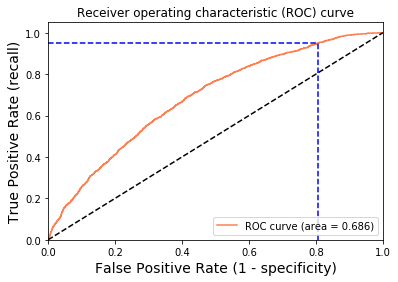

In [236]:
# Show the ROC_CURVE
import numpy as np
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
idx = np.min(np.where(tpr > 0.95))  # index of the first threshold for which the sensibility > 0.95
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [237]:
# Classification_report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.61      0.73      8464
           1       0.23      0.65      0.34      1483

   micro avg       0.62      0.62      0.62      9947
   macro avg       0.57      0.63      0.54      9947
weighted avg       0.81      0.62      0.67      9947



In [238]:
# Accuracy:
y_train_pred=rf_model.predict(x_train)
print('Train Sample Accuracy: %0.4f' % accuracy_score(y_train, y_train_pred))
print('Test Sample Accuracy: %0.4f' % accuracy_score(y_test, y_pred))

Train Sample Accuracy: 0.6448
Test Sample Accuracy: 0.6190


**<font color='#B64D37'>Based on the results, for the loan default prediction in this case, Random Forest model with upsampling performs slightly better than Logistic Regression model with upsampling</font>**